In [1]:
import cv2
import numpy as np
from google.colab import files

In [2]:
video = files.upload()

Saving input_video.mp4 to input_video.mp4


In [3]:
video_path = "/content/input_video.mp4"

In [4]:
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget -q https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names


In [5]:
with open('coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

model = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')

layer_names = model.getLayerNames()
output_layers = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]

In [6]:
x = cv2.VideoCapture(video_path)

In [7]:
fps = x.get(cv2.CAP_PROP_FPS)
width  = int(x.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(x.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [8]:
mp4 = cv2.VideoWriter_fourcc(*'mp4v')
output = cv2.VideoWriter('output.mp4', mp4, fps, (width, height))

In [9]:
z_measurements = []

while True:
    check, frame = x.read()
    if not check:
        break

    (h, w) = frame.shape[:2]

    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    model.setInput(blob)
    layer_outputs = model.forward(output_layers)

    bounding_boxes = []
    classIDs = []
    nms_thresholds = []

    for layer_output in layer_outputs:
        for detection in layer_output:
            scores = detection[5:]
            classID = np.argmax(scores)
            nms_threshold = scores[classID]

            if classes[classID] == 'car':
                bounding_box = detection[0:4] * np.array([w, h, w, h])
                (x_centroid, y_centroid, width_box, height_box) = bounding_box.astype("int")
                z_measurements.append(np.array([x_centroid, y_centroid]))

                x_box = int(x_centroid - (width_box / 2))
                y_box = int(y_centroid - (height_box / 2))

                bounding_boxes.append([x_box, y_box, int(width_box), int(height_box)])
                classIDs.append(classID)
                nms_thresholds.append(float(nms_threshold))

    idxs = cv2.dnn.NMSBoxes(bounding_boxes, nms_thresholds, 0.5, 0.3)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x_box, y_box, w, h) = bounding_boxes[i]
            cv2.rectangle(frame, (x_box, y_box), (x_box + w, y_box + h), (0, 255, 0), 2)
            centroid = (x_box + w // 2, y_box + h // 2)
            cv2.circle(frame, centroid, 5, (0, 0, 255), -1)

    output.write(frame)

x.release()
output.release()

print("Done")

Done


In [10]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=abc8146b594063043fa4b5467a4af5b55a6f07f7c9e83a7fb71f7273d06a3a3e
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [11]:
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

In [12]:
dt = 1/30 #we have 30 fps so each frame is 1/30 seconds

In [13]:
kf = KalmanFilter(dim_x=4, dim_z=2)

kf.F = np.array([[1, 0, dt, 0],
                 [0, 1, 0, dt],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])

kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])

x_0, y_0 = 367, 806
kf.x = np.array([x_0, y_0, 0, 0])

kf.P = np.eye(4) * 500
kf.R = np.eye(2) * 5
kf.Q = np.eye(4) * 0.01

s_preds = []
innovation_vectors = []
innovation_norms = []

for z in z_measurements:
    kf.predict()
    z_pred = kf.H @ kf.x
    innovation = z - z_pred
    innovation_norm = np.linalg.norm(innovation)

    s_preds.append(kf.x.copy())
    innovation_vectors.append(innovation)
    innovation_norms.append(innovation_norm)

    kf.update(z)

innovation_norms = np.array(innovation_norms)

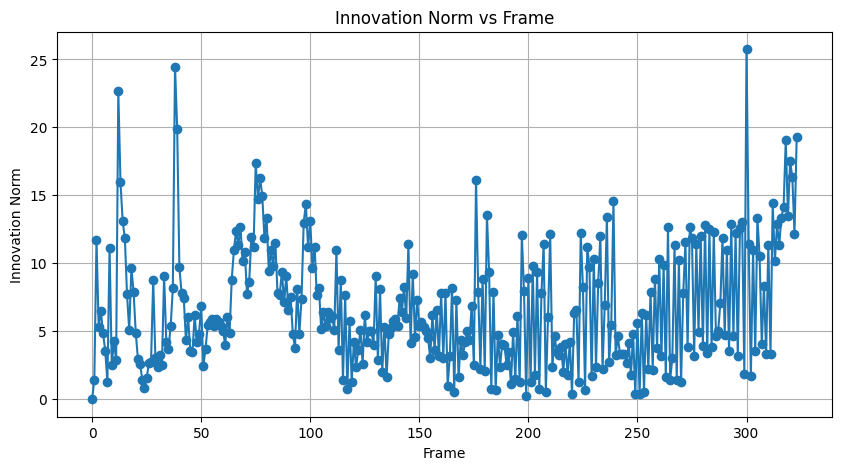

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(innovation_norms, marker='o')
plt.title('Innovation Norm vs Frame')
plt.xlabel('Frame')
plt.ylabel('Innovation Norm')
plt.grid(True)
plt.show()
